# 🧠 FairShap aplicado no Dataset COMPAS
Este notebook demonstra como utilizar o método FairShap para reponderação de dados com foco em fairness, aplicado no dataset COMPAS

# Install/Imports

In [11]:
# 📦 Instalação de dependências (em múltiplas linhas para melhor leitura)
!pip install \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    shap \
    scikit-learn \
    tqdm \
    aif360


In [12]:
# 📚 Importação das bibliotecas principais
import numpy as np
import pandas as pd
import copy
from collections import Counter
import shap

# 🔧 Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# 🔥 Dataset AIF360
from aif360.sklearn.datasets import fetch_compas

# 🔨 Scikit-learn — Pré-processamento e modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

# ⚖️ FairShap — Fairness via Shapley Values
from fairSV.fair_shapley import FairShapley
from fairSV.fair_shapley_sklearn import get_SV_matrix_numba_memory, get_sv_arrays


# Funções Auxiliares

## 🚀 Pipeline de Fairness com FairShap no Dataset COMPAS

 ✔️ Objetivo:
Criar um pipeline modularizado para:
- Avaliar um modelo baseline (sem FairShap).
- Avaliar um modelo com reponderação baseada nos Shapley Values do FairShap.
- Permitir a escolha do atributo sensível (`Caucasian` ou `AfricanAmerican`).
- Testar cenários com ou sem a remoção das colunas sensíveis.

 🔧 Organização do código:
- Função `pipeline_baseline()`: executa o treinamento e avaliação sem usar FairShap.
- Função `pipeline_fairshap()`: calcula os Shapley Values, gera os pesos e executa o pipeline ponderado. Internamente, utiliza `pipeline_baseline()` para reaproveitar o treinamento e avaliação.


In [13]:
#pipeline_baseline

def pipeline_baseline(X_train, X_test, y_train, y_test, weights=None, label="Baseline"):
    """
    Pipeline simples de treinamento e avaliação com GradientBoostingClassifier.
    """
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)
    
    print(f"\n🔍 Resultados para: {label}")
    print(classification_report(y_test, y_pred))
    return model




In [14]:
def pipeline_fairshap(X_train, X_test, y_train, y_test,
                       protected_attribute_col,
                       privileged_value, unprivileged_value,
                       label_favorable, label_unfavorable
                       ):
    """
    Pipeline com FairShap aplicado, incluindo:
    - Cálculo da matriz SV.
    - Cálculo dos Shapley Values fairness-aware.
    - Geração de pesos baseados em uma métrica de justiça.

    Parâmetros:
    - X_train, X_test: Dados de treino e teste (DataFrame ou array).
    - y_train, y_test: Labels.
    - protected_attribute_col: Nome da coluna do atributo sensível.
    - privileged_value: Valor do grupo privilegiado (ex.: 1).
    - unprivileged_value: Valor do grupo não privilegiado (ex.: 0).
    - label_favorable: Label favorável (ex.: 0).
    - label_unfavorable: Label desfavorável (ex.: 1).

    Retorna:
    - weights: Vetor de pesos gerados a partir de Equal Opportunity Normalizado.
    - fair_sv_extractor: Objeto FairShapley com todos os resultados e métricas.
    """
    # ✅ Extrair os valores do atributo sensível no conjunto de teste
    protected_values = X_test[protected_attribute_col].values

    # ✔️ Definir o dicionário do FairShap
    protected_attributes_dict = {
        'values': protected_values,
        'privileged_protected_attribute': privileged_value,
        'unprivileged_protected_attribute': unprivileged_value,
        'favorable_label': label_favorable,
        'unfavorable_label': label_unfavorable
    }

    # 🚀 Criar o objeto FairShap
    fair_sv_extractor = FairShapley(
        X_train.values, y_train,
        X_test.values, y_test,
        protected_attributes_dict=protected_attributes_dict,
        show_plot=False,
        calculate_2dim=True
    )

    # 🔍 Encontrar o melhor K
    best_k, _, _ = fair_sv_extractor.get_best_K()

    # 🔢 Calcular a matriz SV
    _ = fair_sv_extractor.get_SV_matrix(K=best_k)

    # 🔢 Calcular os Shapley Values fairness-aware
    fair_sv_extractor.get_sv_arrays()

    # 🎯 Geração dos pesos com base na Equal Opportunity
    sv_eop = fair_sv_extractor.sv_equal_opportunity_difference
    #normalização
    weights = (sv_eop - np.min(sv_eop)) / (np.max(sv_eop) - np.min(sv_eop))

    return weights, fair_sv_extractor


## Funções de Explicabilidade

In [81]:


def explain_model(model, X_train):
    """
    📊 Explicabilidade global do modelo usando SHAP.
    Mostra a importância média das features no modelo.

    Parâmetros:
    - model: modelo treinado (ex.: GradientBoosting, DecisionTree, RandomForest)
    - X_train: dados de entrada (DataFrame)

    Retorna:
    - Plots de summary SHAP (bar e swarm)
    """
    print("🔍 Gerando explicabilidade global do modelo...")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # 🔥 Plot das importâncias globais (barras)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    plt.show()

    # 🔥 Plot detalhado da distribuição dos impactos
    shap.summary_plot(shap_values, X_train)
    plt.show()

    print("✅ Explicabilidade global gerada com sucesso.")


In [83]:
import shap
from scipy.special import expit
import matplotlib.pyplot as plt

def explain_individual(index, model, X_train):
    """
    🧠 Explicabilidade local com SHAP (versão waterfall).
    Mostra o impacto de cada feature + exibe a probabilidade prevista no gráfico.
    """
    # Obter valores SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    instance = X_train.iloc[[index]]

    # Corrigir acesso ao escalar
    expected_value = explainer.expected_value[0]
    fx = float(shap_values[index].sum() + expected_value)
    prob = float(expit(fx))

    # Construir explicação
    explanation = shap.Explanation(
        values=shap_values[index],
        base_values=expected_value,
        data=instance.values[0],
        feature_names=instance.columns
    )

    # Plot com título seguro (sem emoji)
    shap.plots.waterfall(explanation, show=False)
    plt.title(f"SHAP Waterfall — Instância {index} | Prob. prevista: {prob:.2f}", fontsize=12)
    plt.show()


## Funções de sumário

In [ ]:
def summarize_dataset(df):
    """
    📊 Gera um sumário completo de estatísticas e estrutura do dataset.

    Parâmetros:
    - df: pandas DataFrame

    Retorna:
    - Imprime métricas descritivas e insights úteis sobre as colunas
    """
    import pandas as pd
    import numpy as np

    print("📦 Tamanho do dataset:")
    print(f"- Linhas: {df.shape[0]}")
    print(f"- Colunas: {df.shape[1]}")
    print("\n📄 Primeiras 5 linhas:")
    display(df.head())

    print("\n🔢 Informações básicas:")
    display(df.info())

    print("\n📈 Estatísticas descritivas:")
    display(df.describe().T)

    print("\n🧾 Colunas categóricas/dummies:")
    cat_cols = [col for col in df.columns if df[col].nunique() <= 10 and df[col].dtype in [np.int64, np.bool_, np.int32, object]]
    for col in cat_cols:
        print(f"- {col}: {df[col].unique()} (n={df[col].nunique()})")

    print("\n📊 Correlação entre variáveis numéricas:")
    corr = df.corr(numeric_only=True)
    display(corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2))


    print("\n⚠️ Colunas com valores nulos:")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        display(missing)
    else:
        print("✅ Nenhum valor nulo encontrado.")


In [ ]:
def dist_racial(df,race_columns):
    from IPython.display import display, HTML

    # 📊 Loop para exibir totais e distribuições lado a lado
    for race in race_columns:
        print(f"\n📊 Raça: {race}")
        total = df[race].sum()
        print(f"Total de indivíduos: {int(total)}")

        # 📊 Gerar tabelas
        dist_abs = pd.crosstab(df[race], df['Reincidente'])
        dist_pct = pd.crosstab(df[race], df['Reincidente'], normalize='index').round(3)

        # 🔗 Combinar HTML das duas tabelas
        html = f"""
        <div style="display: flex; gap: 40px;">
            <div>
                <b>Distribuição absoluta:</b>
                {dist_abs.to_html()}
            </div>
            <div>
                <b>Distribuição percentual:</b>
                {dist_pct.to_html()}
            </div>
        </div>
        """
        display(HTML(html))


# Carregando Dataset

In [52]:
# 🚩 Carrega o dataset
dataset = fetch_compas()

# Transforma X em DataFrame para acessar pelo nome da coluna
X = pd.DataFrame(dataset.X)
y = dataset.y

print(X.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc'],
      dtype='object')


# Tratamendo dos dados

 🔧 Plano de pré-processamento dos dados (COMPAS)

Este notebook utiliza um pipeline de pré-processamento projetado para tratar as variáveis não numéricas do dataset COMPAS de forma clara, interpretável e alinhada às boas práticas de fairness.

🔥 Decisões tomadas:

- **`age_cat` → DROP**  
Variável categórica redundante com `age` (numérica), portanto removida.

- **`c_charge_desc` → DROP**  
Descrição textual livre da acusação. Exigiria processamento de linguagem natural (NLP) para ser útil, e não é essencial para o escopo atual.

- **`sex`, `c_charge_degree`,`race`  → One-hot encoding (sem `drop_first`)**  

 🔧 Mapeamento dos Labels

Os labels estão como strings (`'Survived'` e `'Recidivated'`).  
Mapeamos `'Survived' → 0` (não reincidente) e `'Recidivated' → 1` (reincidente).  
Isso é necessário, pois modelos e o FairShap exigem labels numéricos.  

 ✔️ Resultado final das features:

- Colunas numéricas:  
`age`, `juv_fel_count`, `juv_misd_count`, `juv_other_count`, `priors_count`

- Colunas categóricas transformadas:  
`Female`, `Male`, `Felony`, `Misdemeanor`, `Caucasian`, `AfricanAmerican`, etc

 🏗️ Justificativa geral:
Este tratamento mantém a interpretação intuitiva das features, evita ambiguidades e é diretamente aplicável tanto em modelos de machine learning quanto na análise de fairness com FairShap.


In [53]:
# =============================
# 🔥 Tratamento dos categóricos
# =============================

# ✔️ 1. DROP das colunas que não vamos usar
X = X.drop(columns=['age_cat', 'c_charge_desc'])

# ✔️ 2. Mapear 'F' e 'M' de c_charge_degree
X['c_charge_degree'] = X['c_charge_degree'].map({'F': 'Felony', 'M': 'Misdemeanor'})

# ✔️ 3. Criar dummies para 'sex' e 'c_charge_degree' e 'race' (sem drop_first)
X = pd.get_dummies(X, columns=['sex', 'c_charge_degree','race'], drop_first=False)


#para utilizar na avaliação depois
race_columns = [col for col in X.columns if col.startswith('race_')]
race_columns = [col.replace('race_', '') for col in race_columns]


# ✔️ Renomeando colunas para nomes mais simples e diretos
X.columns = [
    name.replace('sex_', '')
        .replace('c_charge_degree_', '')
        .replace('race_', '')
    if any(prefix in name for prefix in ['sex_', 'c_charge_degree_', 'race_'])
    else name
    for name in X.columns
]


# Mapeamento dos labels para 0 e 1
label_map = {'Survived': 0, 'Recidivated': 1}

y = np.array([label_map[val] for val in dataset.y])


print("✔️ Features finais:", X.columns.tolist())

✔️ Features finais: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'Male', 'Female', 'Misdemeanor', 'Felony', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']


### 🔄 Normalização — Por que aplicamos no pipeline?
A normalização é essencial porque o FairShap utiliza KNN, que é sensível à escala das variáveis. Sem normalizar, variáveis com magnitudes maiores dominariam o cálculo de distâncias, distorcendo os Shapley Values e prejudicando o resultado.

Além disso, modelos como Redes Neurais (MLP) também exigem normalização, pois dados em escalas muito diferentes geram gradientes mal condicionados, afetando a estabilidade e a velocidade de convergência do treinamento.

Já modelos como Gradient Boosting (GBC) e árvores de decisão não precisam de normalização, pois são baseados em splits. Porém, mantemos a normalização no pipeline para garantir consistência, já que ela é indispensável para o FairShap e para MLP.

In [54]:
# ========================================
# 🧼 Normalização dos dados (exceto y e A)
# ========================================


# ✔️ Detectar automaticamente variáveis binárias e contínuas
binary_cols = [
    col for col in X.columns
    if set(X[col].unique()).issubset({0, 1})
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

print("✔️ Variáveis binárias:", binary_cols)
print("✔️ Variáveis contínuas:", continuous_cols)

# ✔️ Normalizar apenas as variáveis contínuas
scaler = StandardScaler()
X_continuous = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols
)

# ✔️ Manter as binárias sem alteração
X_binarias = X[binary_cols].reset_index(drop=True)

# ✔️ Concatenar
X_scaled = pd.concat([X_continuous, X_binarias], axis=1)
X_scaled.columns = X.columns

copia = copy.deepcopy(X_scaled)

print("✔️ Dados preparados com sucesso!")
print("Shape de X_scaled:", X_scaled.shape)

✔️ Variáveis binárias: ['Male', 'Female', 'Misdemeanor', 'Felony', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
✔️ Variáveis contínuas: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
✔️ Dados preparados com sucesso!
Shape de X_scaled: (6167, 15)


### 🔄 Sem Normalização — para melhor explicabilidade

In [56]:
X_scaled = X
print(X_scaled.juv_misd_count.unique())
copia = copy.deepcopy(X_scaled)

[ 0  1  6 12  2  4  3  8  5 13]


# Sumário do Dataset

In [97]:
aux = X
aux['Reincidente'] = y
summarize_dataset(aux)
dist_racial(aux,race_columns)


📦 Tamanho do dataset:
- Linhas: 6167
- Colunas: 16

📄 Primeiras 5 linhas:


age  juv_fel_count  juv_misd_count  juv_other_count  \
sex  race                                                                    
Male Other              69              0               0                0   
     African-American   34              0               0                0   
     African-American   24              0               0                1   
     Other              44              0               0                0   
     Caucasian          41              0               0                0   

                       priors_count  Male  Female  Misdemeanor  Felony  \
sex  race                                                                
Male Other                        0  True   False        False    True   
     African-American             0  True   False        False    True   
     African-American             4  True   False        False    True   
     Other                        0  True   False         True   False   
     Caucasian                   14  True   False        False    True   

                       African-American  Asian  Caucasian  Hispanic  \
sex  race                                                             
Male Other                        False  False      False     False   
     African-American              True  False      False     False   
     African-American              True  False      False     False   
     Other                        False  False      False     False   
     Caucasian                    False  False       True     False   

                       Native American  Other  Reincidente  
sex  race                                                   
Male Other                       False   True            0  
     African-American            False  False            1  
     African-American            False  False            1  
     Other                       False   True            0  
     Caucasian                   False  False            1


🔢 Informações básicas:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6167 entries, ('Male', 'Other') to ('Female', 'Hispanic')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   age               6167 non-null   int64
 1   juv_fel_count     6167 non-null   int64
 2   juv_misd_count    6167 non-null   int64
 3   juv_other_count   6167 non-null   int64
 4   priors_count      6167 non-null   int64
 5   Male              6167 non-null   bool 
 6   Female            6167 non-null   bool 
 7   Misdemeanor       6167 non-null   bool 
 8   Felony            6167 non-null   bool 
 9   African-American  6167 non-null   bool 
 10  Asian             6167 non-null   bool 
 11  Caucasian         6167 non-null   bool 
 12  Hispanic          6167 non-null   bool 
 13  Native American   6167 non-null   bool 
 14  Other             6167 non-null   bool 
 15  Reincidente       6167 non-null   int64
dtypes: bool(10), int64(6

None


📈 Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
age,6167.0,34.531863,11.726167,18.0,25.0,31.0,42.0,96.0
juv_fel_count,6167.0,0.059186,0.463630,0.0,0.0,0.0,0.0,20.0
juv_misd_count,6167.0,0.091292,0.498067,0.0,0.0,0.0,0.0,13.0
juv_other_count,6167.0,0.110751,0.470911,0.0,0.0,0.0,0.0,9.0
priors_count,6167.0,3.247446,4.745320,0.0,0.0,1.0,4.0,38.0
Reincidente,6167.0,0.455489,0.498055,0.0,0.0,0.0,1.0,1.0



🧾 Colunas categóricas/dummies:
- juv_fel_count: [ 0  2  1  8  3  4 20  6  5 10] (n=10)
- juv_misd_count: [ 0  1  6 12  2  4  3  8  5 13] (n=10)
- juv_other_count: [0 1 3 4 2 9 5 6 7] (n=9)
- Male: [ True False] (n=2)
- Female: [False  True] (n=2)
- Misdemeanor: [False  True] (n=2)
- Felony: [ True False] (n=2)
- African-American: [False  True] (n=2)
- Asian: [False  True] (n=2)
- Caucasian: [False  True] (n=2)
- Hispanic: [False  True] (n=2)
- Native American: [False  True] (n=2)
- Other: [ True False] (n=2)
- Reincidente: [0 1] (n=2)

📊 Correlação entre variáveis numéricas:


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,Male,Female,Misdemeanor,Felony,African-American,Asian,Caucasian,Hispanic,Native American,Other,Reincidente
age,1.00,-0.05,-0.11,-0.17,0.12,-0.01,0.01,0.10,-0.10,-0.18,0.02,0.18,0.01,-0.00,0.01,-0.19
juv_fel_count,-0.05,1.00,0.08,0.04,0.19,0.05,-0.05,-0.05,0.05,0.06,-0.01,-0.05,-0.02,0.03,0.00,0.08
juv_misd_count,-0.11,0.08,1.00,0.26,0.27,0.05,-0.05,-0.04,0.04,0.09,-0.01,-0.07,-0.03,-0.00,-0.01,0.11
juv_other_count,-0.17,0.04,0.26,1.00,0.11,0.06,-0.06,-0.04,0.04,0.05,-0.01,-0.02,-0.03,-0.00,-0.03,0.13
priors_count,0.12,0.19,0.27,0.11,1.00,0.12,-0.12,-0.15,0.15,0.22,-0.03,-0.15,-0.07,0.02,-0.08,0.29
Male,-0.01,0.05,0.05,0.06,0.12,1.00,-1.00,-0.06,0.06,0.05,0.02,-0.07,0.02,0.00,0.01,0.10
Female,0.01,-0.05,-0.05,-0.06,-0.12,-1.00,1.00,0.06,-0.06,-0.05,-0.02,0.07,-0.02,-0.00,-0.01,-0.10
Misdemeanor,0.10,-0.05,-0.04,-0.04,-0.15,-0.06,0.06,1.00,-1.00,-0.10,0.00,0.08,0.04,0.00,0.01,-0.12
Felony,-0.10,0.05,0.04,0.04,0.15,0.06,-0.06,-1.00,1.00,0.10,-0.00,-0.08,-0.04,-0.00,-0.01,0.12
African-American,-0.18,0.06,0.09,0.05,0.22,0.05,-0.05,-0.10,0.10,1.00,-0.07,-0.74,-0.31,-0.04,-0.25,0.14



⚠️ Colunas com valores nulos:
✅ Nenhum valor nulo encontrado.

📊 Raça: African-American
Total de indivíduos: 3173


Reincidente,0,1
African-American,,
False,1846,1148
True,1512,1661
Reincidente,0,1
African-American,,
False,0.617,0.383
True,0.477,0.523



📊 Raça: Asian
Total de indivíduos: 31


Reincidente,0,1
Asian,,
False,3335,2801
True,23,8
Reincidente,0,1
Asian,,
False,0.544,0.456
True,0.742,0.258



📊 Raça: Caucasian
Total de indivíduos: 2100


Reincidente,0,1
Caucasian,,
False,2080,1987
True,1278,822
Reincidente,0,1
Caucasian,,
False,0.511,0.489
True,0.609,0.391



📊 Raça: Hispanic
Total de indivíduos: 509


Reincidente,0,1
Hispanic,,
False,3038,2620
True,320,189
Reincidente,0,1
Hispanic,,
False,0.537,0.463
True,0.629,0.371



📊 Raça: Native American
Total de indivíduos: 11


Reincidente,0,1
Native American,,
False,3352,2804
True,6,5
Reincidente,0,1
Native American,,
False,0.545,0.455
True,0.545,0.455



📊 Raça: Other
Total de indivíduos: 343


Reincidente,0,1
Other,,
False,3139,2685
True,219,124
Reincidente,0,1
Other,,
False,0.539,0.461
True,0.638,0.362


# Testes

## Aware

### Modelo Nulo

In [75]:
# 🔧 Criando o modelo nulo (sempre prediz a classe mais frequente)

X_scaled = copia.copy()

# 🔀 Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)

# ✅ Descobrir a classe mais frequente no conjunto de treino
classe_mais_frequente = Counter(y).most_common(1)[0][0]

# 🚀 Gerar a predição do modelo nulo (tamanho igual ao y_test)
y_pred_nulo = np.full_like(y_test, fill_value=classe_mais_frequente)

# 🔍 Verificar
print(f"Classe mais frequente no treino: {classe_mais_frequente}")
print(classification_report(y_test, y_pred))


Classe mais frequente no treino: 0
              precision    recall  f1-score   support

           0       0.54      1.00      0.71      1008
           1       0.00      0.00      0.00       843

    accuracy                           0.54      1851
   macro avg       0.27      0.50      0.35      1851
weighted avg       0.30      0.54      0.38      1851



c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

### Baseline - Sem FairShap

In [41]:
X_scaled = copia.copy()

# 🔀 Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)

baseline = pipeline_baseline(X_train, X_test, y_train, y_test, label="Baseline - Sem FairShap")


🔍 Resultados para: Baseline - Sem FairShap
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1008
           1       0.68      0.57      0.62       843

    accuracy                           0.68      1851
   macro avg       0.68      0.67      0.67      1851
weighted avg       0.68      0.68      0.68      1851



### Fair Shap Caucasian

In [42]:
X_scaled = copia.copy()


# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
feature_names = X_scaled.columns.tolist()

weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='Caucasian',
    privileged_value=1,
    unprivileged_value=0,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)



fairshap_causasian = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="Caucasian - Aware - FairShap", weights=weights)


# Calculating TSNE


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:23<00:00, 77.37it/s]



🔍 Resultados para: Caucasian - Aware - FairShap
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1008
           1       0.59      0.59      0.59       843

    accuracy                           0.63      1851
   macro avg       0.63      0.63      0.63      1851
weighted avg       0.63      0.63      0.63      1851



### Fair Shap AfricanAmerican

In [57]:
X_scaled = copia.copy()

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
feature_names = X_scaled.columns.tolist()

weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='African-American',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)

fairshap_african = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="African-American - Aware - FairShap", weights=weights)


# Calculating TSNE


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:22<00:00, 82.41it/s]



🔍 Resultados para: African-American - Aware - FairShap
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      1008
           1       0.66      0.55      0.60       843

    accuracy                           0.67      1851
   macro avg       0.67      0.66      0.66      1851
weighted avg       0.67      0.67      0.66      1851



## Avaliação

In [76]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 🔧 Função para calcular TPR por grupo (Equal Opportunity)
def equal_opportunity(y_true, y_pred, protected):
    groups = np.unique(protected)
    results = {}
    
    for group in groups:
        mask = protected == group
        tp = np.sum((y_true[mask] == 1) & (y_pred[mask] == 1))
        fn = np.sum((y_true[mask] == 1) & (y_pred[mask] == 0))
        
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        
        results[group] = {'TPR': tpr}
    
    return results


# 🔍 Predições dos dois modelos
y_pred_baseline = baseline.predict(X_test)
y_pred_fairshap_caucasian = fairshap_causasian.predict(X_test)
y_pred_fairshap_african = fairshap_african.predict(X_test)


# 🚀 Calcular Equal Opportunity para cada raça
for race in race_columns:
    protected_test = X_test[race].values

    #Modelo Nulo
    eo_nulo = equal_opportunity(y_test, y_pred_nulo, protected_test)
    
    # 🔥 Baseline
    eo_baseline = equal_opportunity(y_test, y_pred_baseline, protected_test)
    
    # 🔥 FairShap - Caucasian
    eo_fairshap_caucasian = equal_opportunity(y_test, y_pred_fairshap_caucasian, protected_test)
    
    # 🔥 FairShap - African American
    eo_fairshap_african = equal_opportunity(y_test, y_pred_fairshap_african, protected_test)

    # 🔧 Formatando saída para mais legibilidade e controlando casas decimais
    def format_eo_output(race, eo_result): 
        return {
            f'{race} S': round(float(eo_result.get(1, {'TPR': 'N/A'})['TPR']), 2) if eo_result.get(1) else 'N/A',
            f'N': round(float(eo_result.get(0, {'TPR': 'N/A'})['TPR']), 2) if eo_result.get(0) else 'N/A'
        }
    
    eo_nulo_output = format_eo_output(race, eo_nulo)
    baseline_output = format_eo_output(race,eo_baseline)
    fairshap_caucasian_output = format_eo_output(race,eo_fairshap_caucasian)
    fairshap_african_output = format_eo_output(race,eo_fairshap_african)

    # ✅ Exibir resultados
    print(f"\n🔍 Equal Opportunity (TPR) para {race}:")
    print(f"Modelo Nulo: {eo_nulo_output}")
    print(f"Baseline: {baseline_output}")
    print(f"FairShap - Caucasian: {fairshap_caucasian_output}")
    print(f"FairShap - African: {fairshap_african_output}")





🔍 Equal Opportunity (TPR) para African-American:
Modelo Nulo: {'African-American S': 0.0, 'N': 0.0}
Baseline: {'African-American S': 0.68, 'N': 0.39}
FairShap - Caucasian: {'African-American S': 0.53, 'N': 0.69}
FairShap - African: {'African-American S': 0.51, 'N': 0.6}

🔍 Equal Opportunity (TPR) para Asian:
Modelo Nulo: {'Asian S': 0.0, 'N': 0.0}
Baseline: {'Asian S': 0.0, 'N': 0.57}
FairShap - Caucasian: {'Asian S': 0.0, 'N': 0.59}
FairShap - African: {'Asian S': 0.0, 'N': 0.54}

🔍 Equal Opportunity (TPR) para Caucasian:
Modelo Nulo: {'Caucasian S': 0.0, 'N': 0.0}
Baseline: {'Caucasian S': 0.37, 'N': 0.65}
FairShap - Caucasian: {'Caucasian S': 0.82, 'N': 0.5}
FairShap - African: {'Caucasian S': 0.61, 'N': 0.52}

🔍 Equal Opportunity (TPR) para Hispanic:
Modelo Nulo: {'Hispanic S': 0.0, 'N': 0.0}
Baseline: {'Hispanic S': 0.47, 'N': 0.57}
FairShap - Caucasian: {'Hispanic S': 0.37, 'N': 0.61}
FairShap - African: {'Hispanic S': 0.57, 'N': 0.54}

🔍 Equal Opportunity (TPR) para Native Amer

## Árvore de Decisão Pesos

In [ ]:
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)


weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='African-American',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1
)

# Calculating TSNE


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:23<00:00, 80.41it/s]


<Figure size 2000x1000 with 0 Axes>

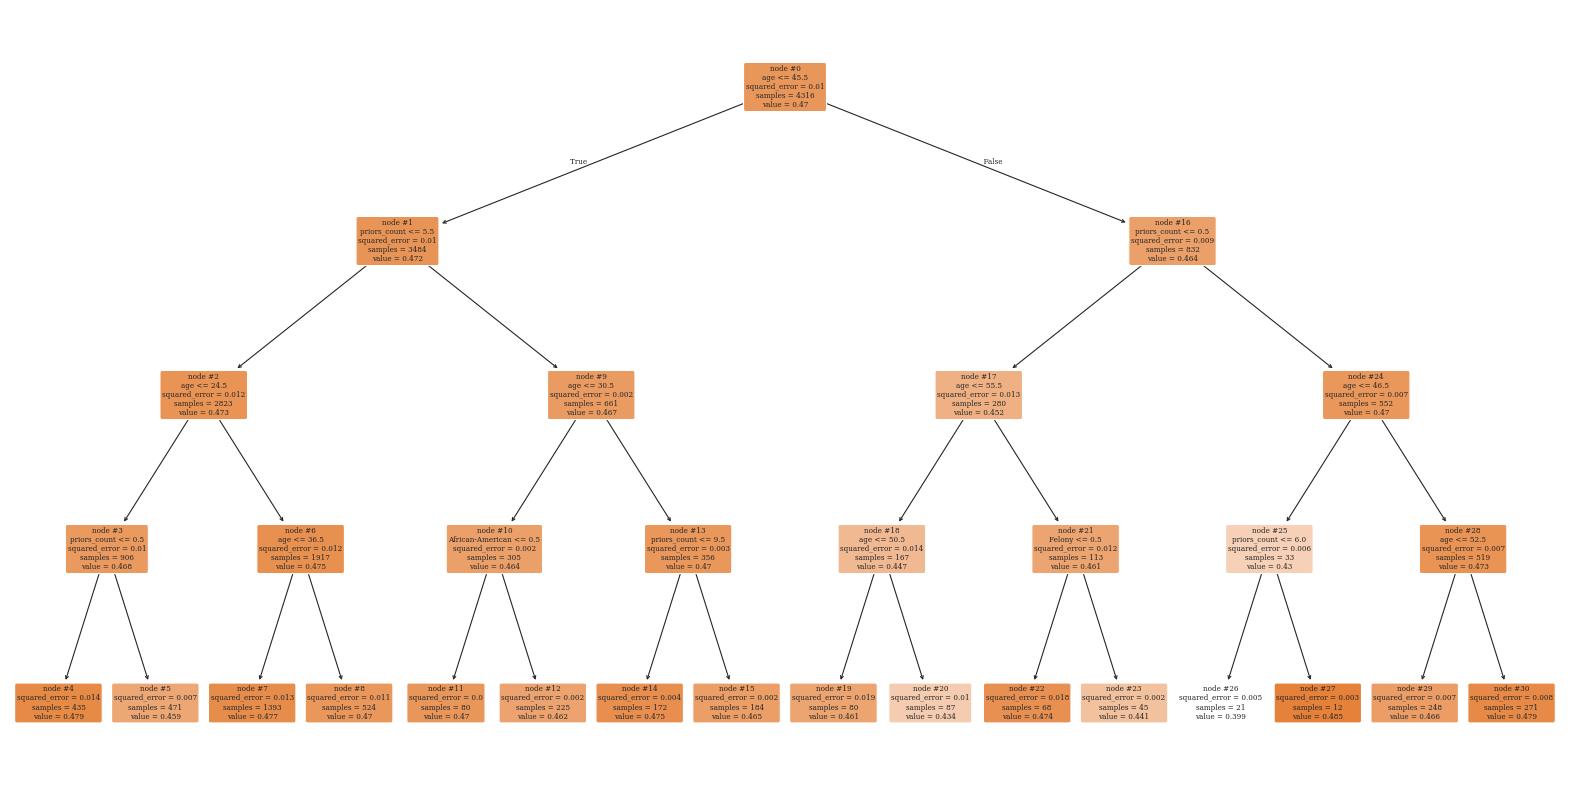

In [97]:
# 🔧 Criar e treinar a árvore de regressão
reg_tree = DecisionTreeRegressor(
    max_depth=4,  # Controla profundidade
    min_samples_leaf=5,  # Evita splits muito pequenos
    random_state=42
)

# 🚀 Treinar a árvore usando os pesos como variável alvo
reg_tree.fit(X_train, weights)

# 🔍 Visualizar a árvore
plt.figure(figsize=(20, 10))
plt.figure(figsize=(20, 10))
tree.plot_tree(
    reg_tree,
    filled=True,
    feature_names=X_train.columns,
    rounded=True,
    node_ids=True
)
plt.show()

In [92]:
# 🔍 Obter o ID da folha para cada amostra
leaf_ids = reg_tree.apply(X_train)

# ✅ Adicionar essa informação ao dataframe
df_leaves = X_train.copy()
df_leaves['leaf_id'] = leaf_ids
df_leaves['peso'] = weights

# 🔧 Agrupar por folha e calcular estatísticas
summary = df_leaves.groupby('leaf_id').agg(
    count=('peso', 'count'),
    peso_medio=('peso', 'mean'),
    peso_min=('peso', 'min'),
    peso_max=('peso', 'max')
).reset_index()

print(summary)


    leaf_id  count  peso_medio  peso_min  peso_max
0         4    435    0.478940  0.107003  0.835454
1         5    471    0.458669  0.242653  0.699669
2         7   1393    0.476649  0.000000  0.927665
3         8    524    0.469557  0.247658  0.934342
4        11     80    0.470138  0.441073  0.541498
5        12    225    0.461578  0.394473  0.736670
6        14    172    0.474926  0.300260  0.639867
7        15    184    0.465075  0.378782  0.625461
8        19     80    0.460807  0.313932  1.000000
9        20     87    0.433573  0.200264  0.803916
10       22     68    0.474218  0.361797  0.956256
11       23     45    0.441099  0.397308  0.621248
12       26     21    0.399101  0.289699  0.566247
13       27     12    0.484730  0.379076  0.572887
14       29    248    0.465863  0.178416  0.816625
15       30    271    0.478829  0.355099  0.843631


In [ ]:
# 🔍 Obter o ID da folha para cada amostra
leaf_ids = reg_tree.apply(X_train)

# ✅ Adicionar essa informação ao dataframe
df_leaves = X_train.copy()
df_leaves['leaf_id'] = leaf_ids
df_leaves['peso'] = weights
df_leaves['Recidivated'] = y_train

# 🔧 Gerar sumário estatístico das features dentro de cada folha
#summary = df_leaves.groupby('leaf_id')[['age', 'priors_count', 'peso']].agg(['mean', 'min', 'max', 'count'])
summary = df_leaves.groupby('leaf_id')[['age', 'priors_count', 'peso']].agg(['mean', 'count'])


# 🔍 Exibir o sumário
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
print(summary)


               age               juv_fel_count               juv_misd_count  \
              mean min max count          mean min max count           mean   
leaf_id                                                                       
4        22.002299  19  24   435      0.000000   0   0   435       0.000000   
5        22.201699  19  24   471      0.116773   0   5   471       0.227176   
7        29.620244  25  36  1393      0.015793   0   2  1393       0.024408   
8        40.446565  37  45   524      0.000000   0   0   524       0.001908   
11       26.675000  20  30    80      0.075000   0   4    80       0.325000   
12       27.062222  21  30   225      0.288889   0   8   225       0.506667   
14       36.494186  31  45   172      0.116279   0   3   172       0.098837   
15       36.456522  31  45   184      0.396739   0  10   184       0.445652   
19       47.937500  46  50    80      0.000000   0   0    80       0.000000   
20       53.000000  51  55    87      0.000000   0  

In [104]:
# 🔧 Obter o ID da folha
leaf_ids = reg_tree.apply(X_train)

# 🔧 Construir dataframe com leaf_id e pesos
df_leaves = X_train.copy()
df_leaves['leaf_id'] = leaf_ids
df_leaves['peso'] = weights
df_leaves['Recidivated'] = y_train

# 🔧 Calcular a média de cada atributo por folha
means = df_leaves.groupby('leaf_id')[['peso','Recidivated','age', 'priors_count', 'Male', 'Misdemeanor', 'Felony', 'African-American']].mean()
#'juv_fel_count', 'juv_misd_count', 'juv_other_count' 'Female',
# 🔧 Calcular contagem de amostras por folha
counts = df_leaves.groupby('leaf_id').size().rename('count')

# 🔧 Adicionar a contagem como coluna no dataframe de médias
summary = means.copy()
summary['count'] = counts

# 🔍 Visualizar
pd.set_option('display.max_columns', None)
print(summary)



             peso  Recidivated        age  priors_count      Male  \
leaf_id                                                             
4        0.478940     0.388506  22.002299      0.000000  0.756322   
5        0.458669     0.653928  22.201699      1.938429  0.853503   
7        0.476649     0.415650  29.620244      1.577889  0.774587   
8        0.469557     0.286260  40.446565      1.309160  0.774809   
11       0.470138     0.775000  26.675000      8.400000  0.850000   
12       0.461578     0.866667  27.062222     10.102222  0.920000   
14       0.474926     0.563953  36.494186      7.343023  0.848837   
15       0.465075     0.744565  36.456522     15.423913  0.902174   
19       0.460807     0.212500  47.937500      0.000000  0.775000   
20       0.433573     0.206897  53.000000      0.000000  0.701149   
22       0.474218     0.132353  62.911765      0.000000  0.838235   
23       0.441099     0.088889  60.977778      0.000000  0.822222   
26       0.399101     0.428571  46

In [100]:
print(stats.shape)

(16, 49)


## Pesos e Quartis

In [109]:
# 🔧 Adicionar os pesos ao dataset
df_quartil = X_train.copy()
df_quartil['peso'] = weights
df_quartil['Recidivated'] = y_train

# 🔧 Definir os quartis
df_quartil['grupo_peso'] = pd.qcut(df_quartil['peso'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# 🔧 Calcular a média dos atributos por grupo de peso
summary = df_quartil.groupby('grupo_peso')[['peso','Recidivated','African-American','age', 'priors_count', 'Male', 'Misdemeanor', 'Felony','juv_fel_count', 'juv_misd_count', 'juv_other_count']].mean()

# 🔧 Adicionar a contagem
summary['count'] = df_quartil.groupby('grupo_peso').size()

# 🔍 Visualizar
pd.set_option('display.max_columns', None)
print(summary)


                peso  Recidivated  African-American        age  priors_count  \
grupo_peso                                                                     
Q1          0.361000     0.474513          0.468026  34.892493      1.574606   
Q2          0.435891     0.482854          0.450417  36.470806      4.410565   
Q3          0.483049     0.484708          0.512512  33.909175      4.733086   
Q4          0.600779     0.379981          0.610751  32.699722      2.156627   

                Male  Misdemeanor    Felony  juv_fel_count  juv_misd_count  \
grupo_peso                                                                   
Q1          0.878591     0.349398  0.650602       0.004634        0.008341   
Q2          0.767377     0.346617  0.653383       0.064875        0.082484   
Q3          0.784059     0.339203  0.660797       0.144578        0.240964   
Q4          0.810009     0.353105  0.646895       0.020389        0.022243   

            juv_other_count  count  
grupo_peso   

C:\Users\Davi Araujo\AppData\Local\Temp\ipykernel_38828\1663101143.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_quartil.groupby('grupo_peso')[['peso','Recidivated','African-American','age', 'priors_count', 'Male', 'Misdemeanor', 'Felony','juv_fel_count', 'juv_misd_count', 'juv_other_count']].mean()
C:\Users\Davi Araujo\AppData\Local\Temp\ipykernel_38828\1663101143.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['count'] = df_quartil.groupby('grupo_peso').size()


In [112]:
# 🔧 Adicionar os pesos ao dataframe
df_bins = X_train.copy()
df_bins['peso'] = weights
df_bins['Recidivated'] = y_train

# 🔧 Definir o número de grupos (bins)
n_bins = 10  # ➕ Altere esse número para quantos grupos quiser

# 🔧 Gerar os labels automaticamente
labels = [f'P {(i+1)/n_bins}' for i in range(n_bins)]

# 🔧 Criar os grupos usando pd.qcut (divisão por quantis, igual número de amostras por grupo)
df_bins['grupo_peso'] = pd.qcut(df_bins['peso'], q=n_bins, labels=labels)

# 🔧 Calcular a média dos atributos por grupo
summary = df_bins.groupby('grupo_peso')[['peso','Recidivated','African-American','age', 'priors_count', 'Male', 'Misdemeanor', 'Felony','juv_fel_count', 'juv_misd_count', 'juv_other_count']].mean()

# 🔧 Adicionar a contagem
summary['count'] = df_bins.groupby('grupo_peso').size()

# 🔍 Visualizar
pd.set_option('display.max_columns', None)
print(summary)


                peso  Recidivated  African-American        age  priors_count  \
grupo_peso                                                                     
P 0.1       0.312948     0.645833          0.645833  31.180556      1.099537   
P 0.2       0.386446     0.347222          0.340278  37.590278      1.722222   
P 0.3       0.411671     0.368910          0.343387  36.925754      2.575406   
P 0.4       0.432004     0.465278          0.439815  37.583333      3.972222   
P 0.5       0.449307     0.566125          0.526682  35.129930      5.598608   
P 0.6       0.465192     0.659722          0.488426  32.956019      6.925926   
P 0.7       0.486443     0.375870          0.501160  34.828306      3.406032   
P 0.8       0.521348     0.296296          0.659722  33.032407      2.775463   
P 0.9       0.565192     0.287703          0.698376  32.146172      2.749420   
P 1.0       0.671319     0.541667          0.460648  33.560185      1.365741   

                Male  Misdemeanor    Fe

C:\Users\Davi Araujo\AppData\Local\Temp\ipykernel_38828\3082716986.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_bins.groupby('grupo_peso')[['peso','Recidivated','African-American','age', 'priors_count', 'Male', 'Misdemeanor', 'Felony','juv_fel_count', 'juv_misd_count', 'juv_other_count']].mean()
C:\Users\Davi Araujo\AppData\Local\Temp\ipykernel_38828\3082716986.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['count'] = df_bins.groupby('grupo_peso').size()


## Testes de explicabilidade

### Explain Model

🧠 Dica para lembrar:
Posição no eixo X = impacto
Cor do ponto = valor da variável


🔍 Gerando explicabilidade global do modelo...


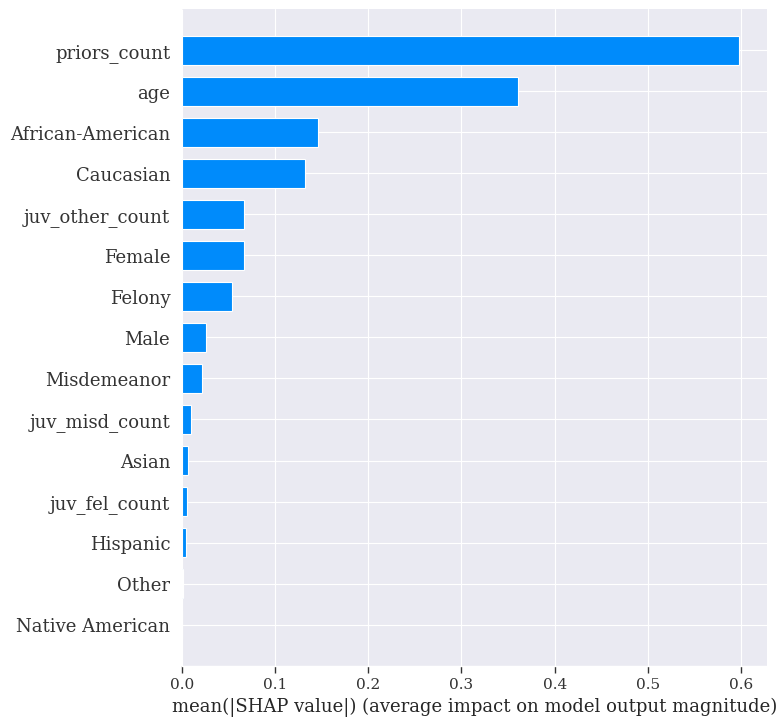

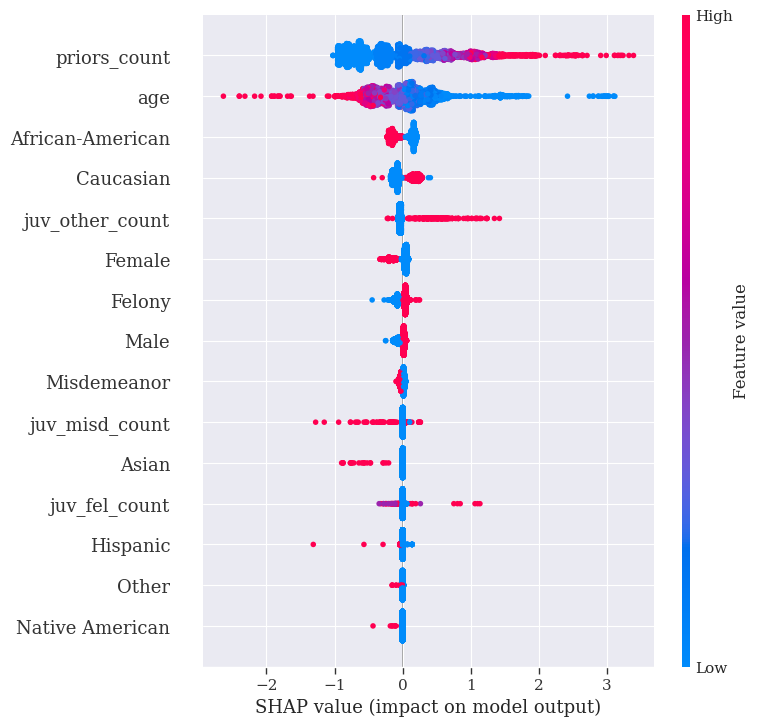

✅ Explicabilidade global gerada com sucesso.


In [66]:
explain_model(fairshap_african, X_train)



### Explain Individual


🔍 Explicabilidade local para a instância 0:


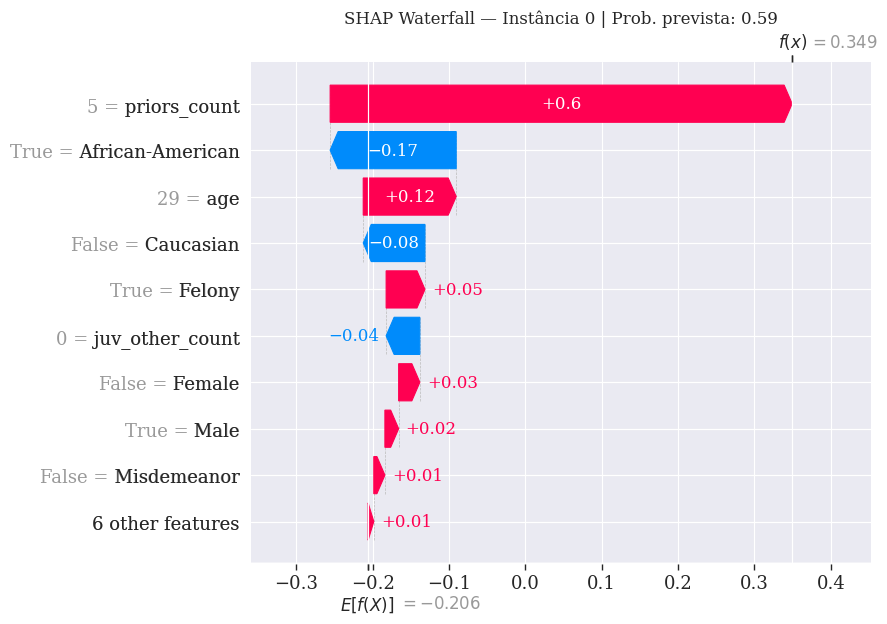


🔍 Explicabilidade local para a instância 1:


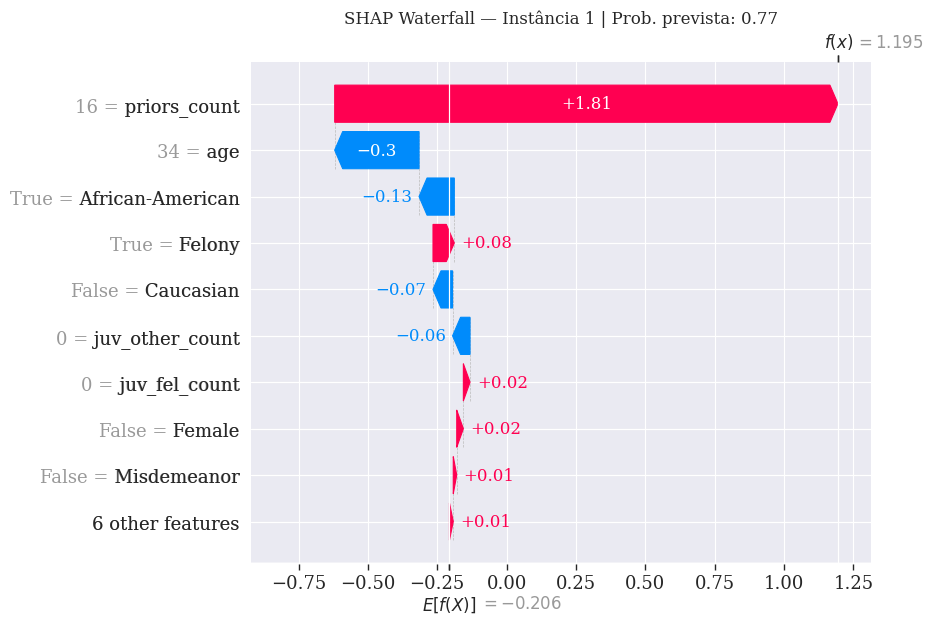


🔍 Explicabilidade local para a instância 2:


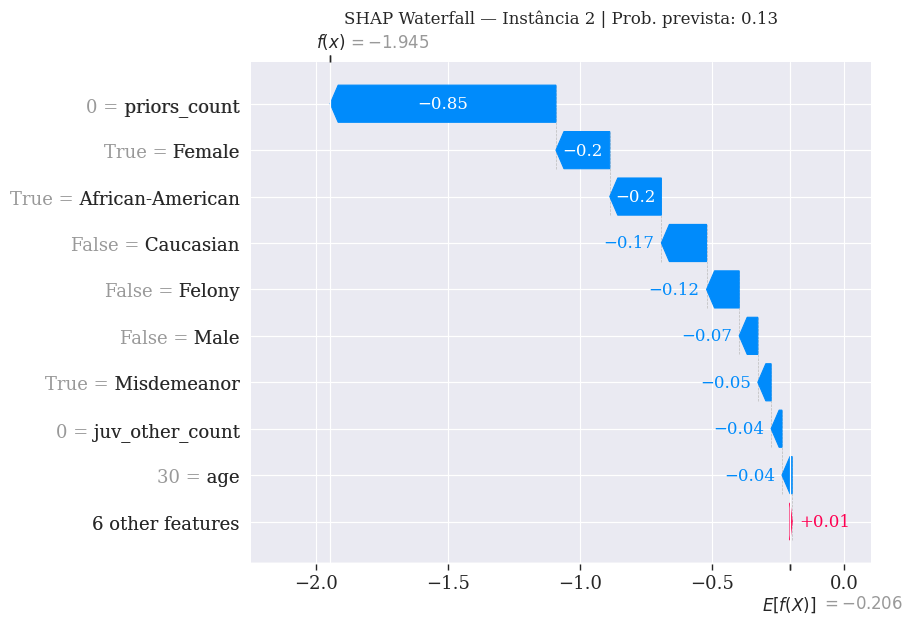


🔍 Explicabilidade local para a instância 3:


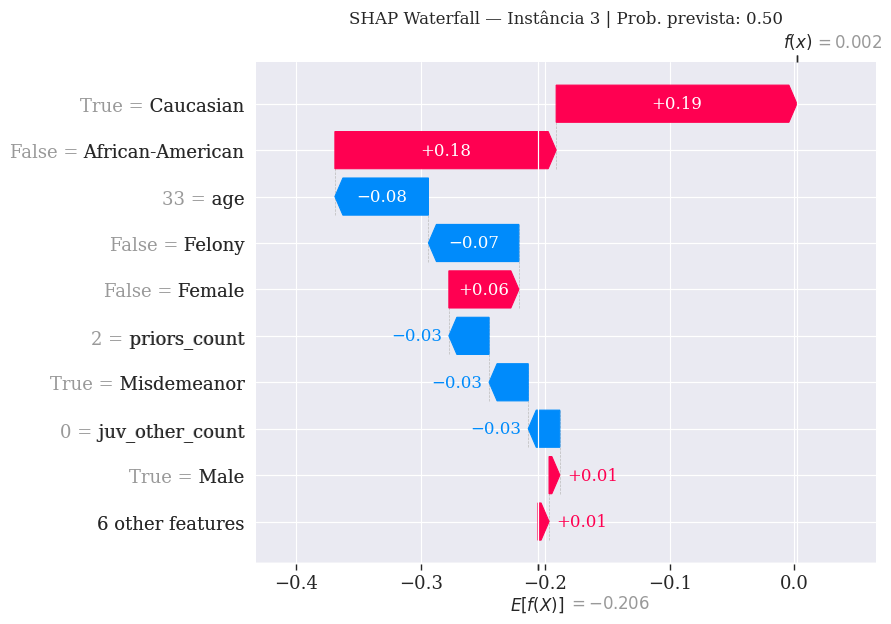


🔍 Explicabilidade local para a instância 4:


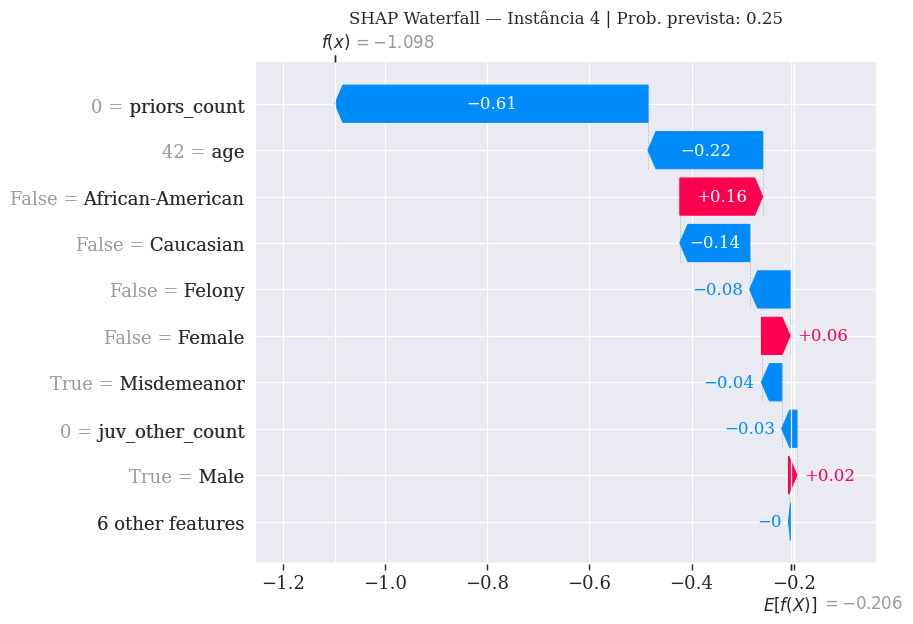

In [84]:
for index in range(5):
    print(f"\n🔍 Explicabilidade local para a instância {index}:")
    explain_individual(index=index, model=fairshap_african, X_train=X_train)

## Unaware